# Clustering test data and evaluating clustering technique with it

In [1]:
from bs4 import BeautifulSoup

f = open('test_data/1957284403.ofs.gold.xml', 'r')
article_text = f.read();
soup = BeautifulSoup(article_text, "lxml")

comment = {
    "bloggerId": "author",
    "sentences": [], # all sentences in a comment,
    "parents": [] # the order depends on how beautifulsoup gives me the parents
}
article = {
    "sentences": {}, # each sentence goes here, hashed by id
    "comments": {} # each comment goes here, hashed by id
}
commentsHTML = soup.findAll('comment')
print commentsHTML[0]
for c in commentsHTML:
    comment_sentences = []
    comment_parents = []
    

<comment bloggerid="epinoa" id="c0">
<s id="s57">[epinoa] So BT and Vodafone breached the Data Protection Act ? </s>
<comment bloggerid="enfrance " id="c1">
<s id="s58">[enfrance ] Is this Atlantic Bridge in operation ? </s>
</comment>
<comment bloggerid="alex442" id="c2">
<s id="s59">[alex442] Human Rights ? </s>
<s id="s60">Aww , how quaint ... </s>
</comment>
<comment bloggerid="nitpiqin " id="c3">
<s id="s61">[nitpiqin ] That 's what we need to judge them and prosecute them with their own laws . </s>
<s id="s62">They are breaking their own laws . </s>
</comment>
<comment bloggerid="MirandaKeen " id="c4">
<s id="s63">[MirandaKeen ] In the near future , I hope . </s>
</comment>
<comment bloggerid="MirandaKeen " id="c5">
<s id="s64">[MirandaKeen ] And the Universal Declaration of Human RightsArticle 12No one shall be subjected to arbitrary interference with their privacy , family , home or correspondence , nor to attacks upon their honour and reputation . </s>
<s id="s65">Everyone has

# Can I extract just the sentence that belongs to the replied comment?

In [2]:
html = commentsHTML[0]
comms = html.findAll('comment')
first_comm_s = html.findAll('s', recursive=False)
first_comm_s


[<s id="s57">[epinoa] So BT and Vodafone breached the Data Protection Act ? </s>]

# Can I extract all the comment tags, including the nested ones?

Turns out the findAll is recursive and gets me every comment.
From there, getting the parents is easy.

In [3]:
for c in commentsHTML:
    if c['id'] == "c4":
        print c
        print [p['id'] for p in c.findParents("comment")]
        break

<comment bloggerid="MirandaKeen " id="c4">
<s id="s63">[MirandaKeen ] In the near future , I hope . </s>
</comment>
['c0']


# Therefore, the function to extract the comments is:

In [4]:
def parse_comments(comments):
    '''
    comment = {
        "bloggerId": "author",
        "sentences": [], # all sentences in a comment,
        "parents": [] # the order depends on how beautifulsoup gives me the parents
    }
    '''
    
    parsed_comments = {}
    for c in comments:
        comment = {}
        comment['bloggerId'] = c['bloggerid']
        
        comment['sentences_ids'] = [s['id'] for s in c.findAll('s', recursive=False)]
        comment['parents'] = [p['id'] for p in c.findParents("comment")]
        parsed_comments[c['id']] = comment
    
    return parsed_comments

In [5]:
import json
import pprint
def parse_article(html):
    soup = BeautifulSoup(html, "lxml")
    
    sentences = soup.findAll('s')
    parsed_sentences = {}
    for s in sentences:
        parsed_sentences[s['id']] = s.get_text() 
    
    parsed_comments = parse_comments(soup.findAll('comment'))
    
    article = {
        'sentences': parsed_sentences,
        'comments': parsed_comments
    }

    return article

article = parse_article(article_text)
pprint.pprint(article)
json_article = json.dumps(article, indent=4)
print len(article['comments'].values()), " comments parsed."
print len(article['sentences'].values()), " sentences parsed."

{'comments': {'c0': {'bloggerId': 'epinoa',
                     'parents': [],
                     'sentences_ids': ['s57']},
              'c1': {'bloggerId': 'enfrance ',
                     'parents': ['c0'],
                     'sentences_ids': ['s58']},
              'c10': {'bloggerId': 'dennis79',
                      'parents': [],
                      'sentences_ids': ['s73', 's74', 's75', 's76', 's77']},
              'c11': {'bloggerId': 'SpecialRX',
                      'parents': ['c10'],
                      'sentences_ids': ['s78', 's79']},
              'c12': {'bloggerId': ' Malkatrinho',
                      'parents': ['c10'],
                      'sentences_ids': ['s80', 's81']},
              'c13': {'bloggerId': 'timetorememberagain ',
                      'parents': [],
                      'sentences_ids': ['s82',
                                        's83',
                                        's84',
                                        's85

# Clustering just the sentences

## Vectorizing the sentences (TFIDF)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer=super(StemmedTfidfVectorizer,self).build_analyzer()
        return lambda doc:(english_stemmer.stem(w) for w in analyzer(doc))

vectorizer = StemmedTfidfVectorizer(min_df=1, stop_words='english',
                                    )

sentences_vectors = vectorizer.fit_transform(article['sentences'].values())
sorted_feature_indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n_features = 20
top_features = [features[i] for i in sorted_feature_indices[:top_n_features]]

print "%d features found" % (len(features))
print "Top %d features:" % (top_n_features)
print top_features

NameError: name 'np' is not defined

## Dimensionality reduction and Normalization

In [117]:
import gensim
#Dimensionality reduction using LSI. Go from 6D to 2D.

X = sentences_vectors.todense()
dct = gensim.corpora.Dictionary(X)
lsi_docs = {}
num_topics = 500
lsi_model = gensim.models.LsiModel(dct, num_topics=500)
print lsi_model.shape
print lsi_model[:50]

UnicodeDecodeError: 'utf8' codec can't decode byte 0xaf in position 1193: invalid start byte

## Clustering with MeanShift

WHY ARE ALL VECTORS VALUED AT 0!???

In [118]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print "Number of estimated clusters : %d" % n_clusters_

# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o',
            markerfacecolor=col, markeredgecolor='k',
            markersize=14)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


Number of estimated clusters : 1


## Using the same approach as a movie clusterer
http://brandonrose.org/clustering

### Imports

In [7]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

### Stopwords, stemming, and tokenizing

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
print 'Done'

Done


In [10]:
def tokenize_and_stem(sentences):
    tokens = [word for sent in sentences 
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(sentences):
    tokens = [word.lower() for sent in sentences
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#### Make vocabulary
stemmmed and not-stemmed

In [11]:
totalvocab_stemmed = []
totalvocab_tokenized = []
allwords_stemmed = tokenize_and_stem(article['sentences'].values())
totalvocab_stemmed.extend(allwords_stemmed)

allwords_tokenized = tokenize_only(article['sentences'].values())
totalvocab_tokenized.extend(allwords_tokenized)

#### Pandas data frame to visualize the vocabulary

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized},
                          index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'
print 'here are the first words in the vocabulary'
vocab_frame.head()

there are 3352 items in vocab_frame
here are the first words in the vocabulary


,words
to,to
those,those
corrupt,corrupted
by,by
greed,greed


### TF-IDF and document similarity

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(article['sentences'].values())

print tfidf_matrix.shape

CPU times: user 2.03 s, sys: 83.9 ms, total: 2.12 s
Wall time: 2.06 s
(190, 120)


In [15]:
terms = tfidf_vectorizer.get_feature_names()

#### Cosine Similarity

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist_frame = pd.DataFrame(dist)
print dist

[[  0.00000000e+00   6.32368721e-01   4.41392655e-01 ...,   5.46565074e-01
    4.36723114e-01   5.89894745e-01]
 [  6.32368721e-01   0.00000000e+00   6.96169781e-01 ...,   6.60962208e-01
    6.80822683e-01   7.49110606e-01]
 [  4.41392655e-01   6.96169781e-01  -2.22044605e-16 ...,   5.77924745e-01
    4.60548146e-01   6.25575149e-01]
 ..., 
 [  5.46565074e-01   6.60962208e-01   5.77924745e-01 ...,   3.33066907e-16
    3.86541760e-01   4.06016946e-01]
 [  4.36723114e-01   6.80822683e-01   4.60548146e-01 ...,   3.86541760e-01
   -2.22044605e-16   4.31044747e-01]
 [  5.89894745e-01   7.49110606e-01   6.25575149e-01 ...,   4.06016946e-01
    4.31044747e-01   0.00000000e+00]]


### K-means clustering

In [18]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 112 ms, sys: 1.56 ms, total: 113 ms
Wall time: 115 ms


In [19]:
clusters

[1,
 2,
 0,
 0,
 0,
 4,
 0,
 0,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 1,
 2,
 1,
 3,
 4,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 0,
 0,
 0,
 4,
 4,
 1,
 1,
 4,
 4,
 0,
 4,
 0,
 0,
 1,
 3,
 2,
 1,
 0,
 1,
 0,
 1,
 3,
 0,
 3,
 0,
 1,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 3,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 3,
 0,
 1,
 0,
 4,
 2,
 4,
 3,
 4,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 3,
 1,
 3,
 0,
 3,
 0,
 1,
 2,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 3,
 1,
 4,
 1,
 1,
 2,
 1,
 2,
 3,
 0,
 0,
 3,
 3,
 1,
 0,
 0,
 3,
 0,
 1,
 3,
 0,
 0,
 1,
 0,
 3,
 3,
 0,
 0,
 3,
 3,
 3,
 1,
 1,
 3,
 0,
 0,
 1,
 3,
 0,
 0,
 1,
 3,
 1,
 4,
 4,
 0,
 0,
 1,
 3,
 0,
 0,
 3,
 3,
 1]

#### Multidimensional scaling to plot?

In [20]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)

xs, ys = pos[:,0], pos[:, 1]

#### Plot

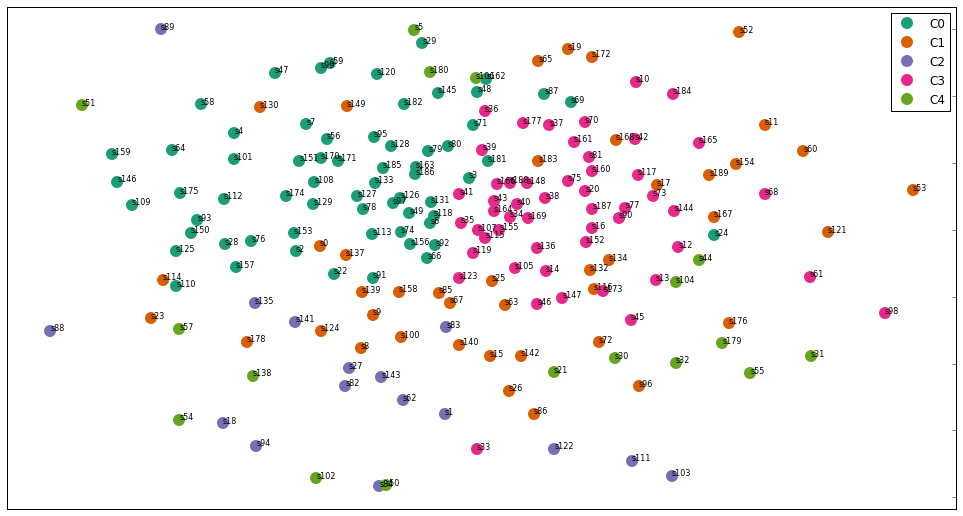

In [21]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_names = {0: 'C0',
                 1: 'C1',
                 2: 'C2',
                 3: 'C3',
                 4: 'C4'}

# iPython now will show matplotlib plots inline
%matplotlib inline

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=["s{0}".format(x) for x in range(190)]))

groups = df.groupby('label')

### set up the plot
fig, ax = plt.subplots(figsize=(17,9))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='',
           ms=12, label=cluster_names[name], color=cluster_colors[name],
           mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis='x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(\
        axis='y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
ax.legend(numpoints=1)

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'],
           size=8)
    
plt.show()


In [23]:
print article['sentences']['s151']
print article['sentences']['s170']
print article['sentences']['s171']
print article['sentences']['s108']

[ScepticOptimist ] And it is exactly the only way we can regain our freedom - a British spring ; mass protest & civil disobedience . 
Large numbers of web apps and traffic is ssl encrypted now so why bother creating a massive fiber intercept program if you could n't see 60 % + of all the traffic and almost all of the communications data ? 
[nowwhataretheyupto] so this is why the government go easy on these toss pots not paying corporation tax . 
[ Malkatrinho] that 's a lovely shade of green . 


In [24]:
print article['sentences']['s93']
print article['sentences']['s150']
print article['sentences']['s114']
print article['sentences']['s110']

With luck we might even stage mass demonstrations demanding our rights . 
They 're terrified that the same kind of mass protests that swept Brazil , Turkey , Bulgaria or the Middle East will eventually be provoked in the West . 
cui bonno ? 
Lots of ISPs use them for their transatlantic traffic . 


## Hierarchical document clustering
The *Ward clustering algorithm* !!!!

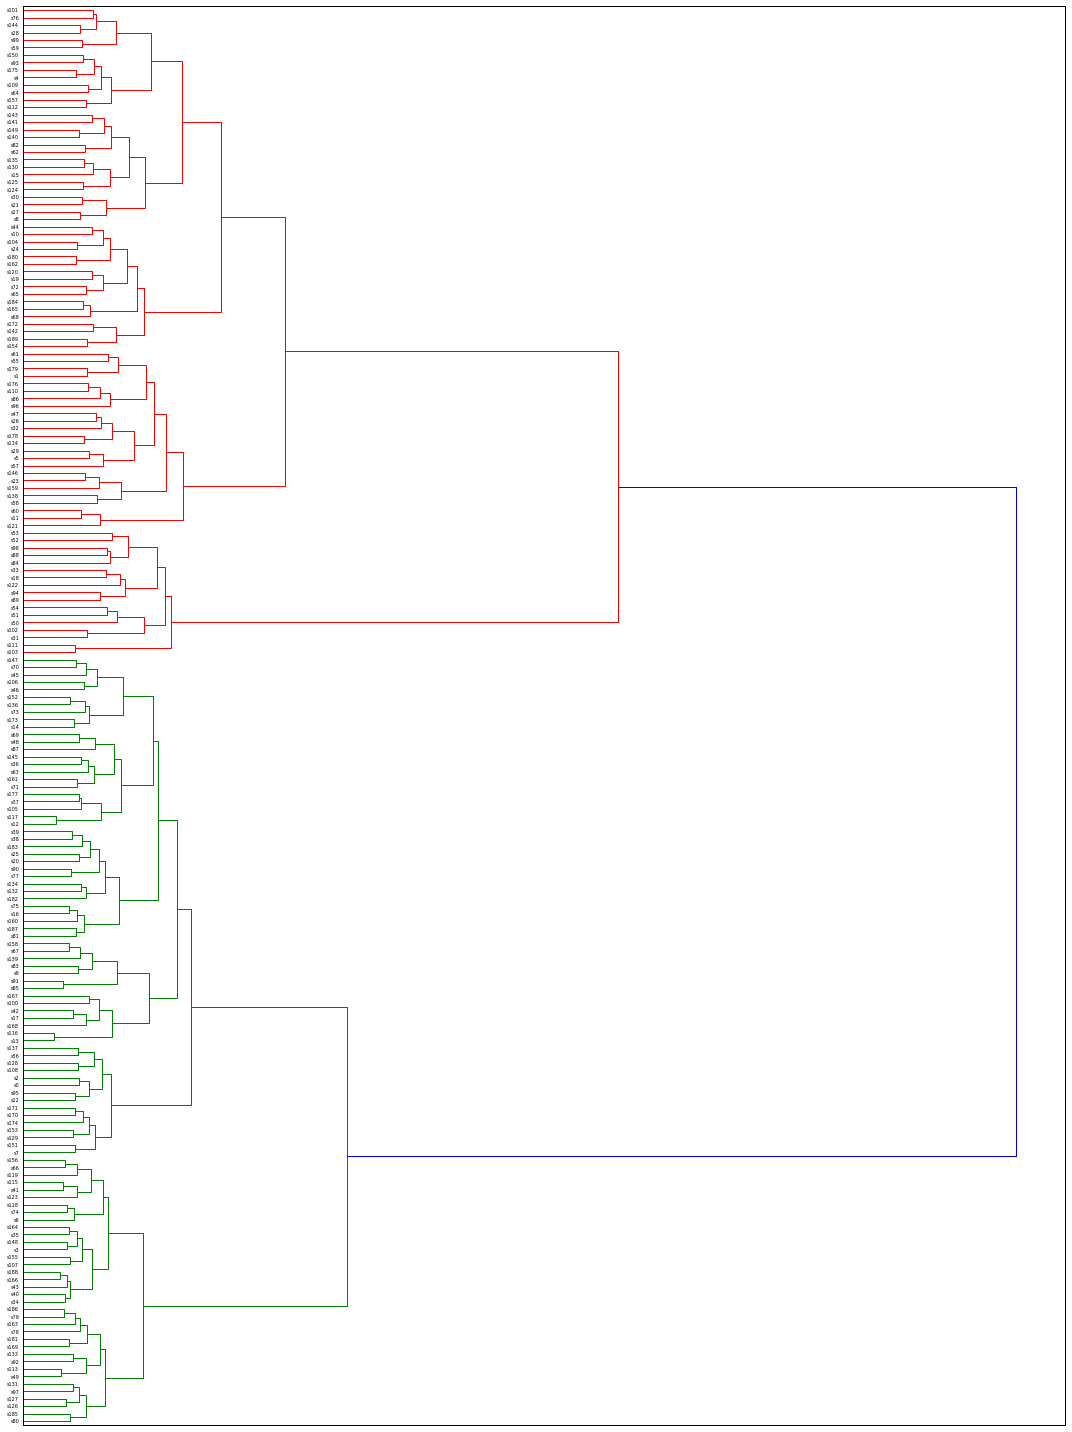

In [26]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) #define the linkage_matrix
# using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15,20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=["s{0}".format(x) for x in range(190)])

plt.tick_params(\
               axis = 'x',
               which ='both',
               bottom ='off',
               top = 'off',
               labelbottom = 'off')

plt.tight_layout()

plt.savefig('ward_clusters.png', dpi=200) 

In [52]:
frame = pd.DataFrame(linkage_matrix)
frame.sort_values(2,axis=0, ascending=False)


,0,1,2,3
188,376,377,21.858239,190
187,369,375,13.101199,87
186,356,373,7.130920,103
185,372,374,5.770700,70
184,358,371,4.347340,46
183,335,370,3.707320,67
182,308,368,3.510684,24
181,359,362,3.493877,29
180,361,366,3.393611,52
179,222,367,3.253098,17
